In [6]:
import pandas as pd
from pandas import Series
from matplotlib import pyplot as plt
import math, matplotlib

In [7]:
pd.set_option('display.min_rows', 20)
deadlines = ['09/23/2020','10/07/2020','10/19/2020','10/30/2020','11/11/2020','11/25/2020','12/09/2020','12/15/2020']
days_left = []
date_list = []
join_list = []
leave_list = []
table = pd.read_csv('officehours.csv', delimiter=',', error_bad_lines=False)
table
for idx,line in table.iterrows():
    date = line['First join'].split()[0]
    month = int(date.split('/')[0])
    day = int(date.split('/')[1])
    date_list.append(date)
    join_list.append(line['First join'].split()[1])
    leave_list.append(line['Last leave'].split()[1])
    #bull = False
    for dd in deadlines:
        if month < int(dd.split('/')[0]):
            days = (30-day) + int(dd.split('/')[1])
            days_left.append(days)
            #bull = True
            break
        elif month == int(dd.split('/')[0]) and day <= int(dd.split('/')[1]):
            days = int(dd.split('/')[1]) - day
            days_left.append(days)
            #bull = True
            break
        ##########   
        # This one considers projects n days after the deadline!
        ##########
        elif month == int(dd.split('/')[0]) and (day - int(dd.split('/')[1])) < 4:
            days_left.append(int(dd.split('/')[1])-day)
            #bull = True
            break
        elif month == int(dd.split('/')[0])+1 and (day + 30 - int(dd.split('/')[1])) < 4:
            days_left.append(-1*(day + 30 - int(dd.split('/')[1])))
            break
        
        elif month == 12 and day == 20:
            days_left.append(-5)
            #bull = True
            break
        
    #if (not bull):
    #    print(idx, date)

table = table.drop(columns=['Name'])
table['Days before deadline'] = days_left
table['Date'] = date_list
table['Join'] = join_list
table['Leave'] = leave_list

In [8]:
presenter_table = table[table['Role'] == 'Presenter']
mod_table = table[table['Role'] == 'Moderator']

def get_ax(size=(3,3), font=18):
    matplotlib.rcParams["font.size"] = font
    fig, ax = plt.subplots(figsize=size)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

def convert_time(time):
    hr = time.split(':')[0]
    mins = time.split(':')[1]
    total_mins = int(mins) + (int(hr)*60)
    return total_mins/60

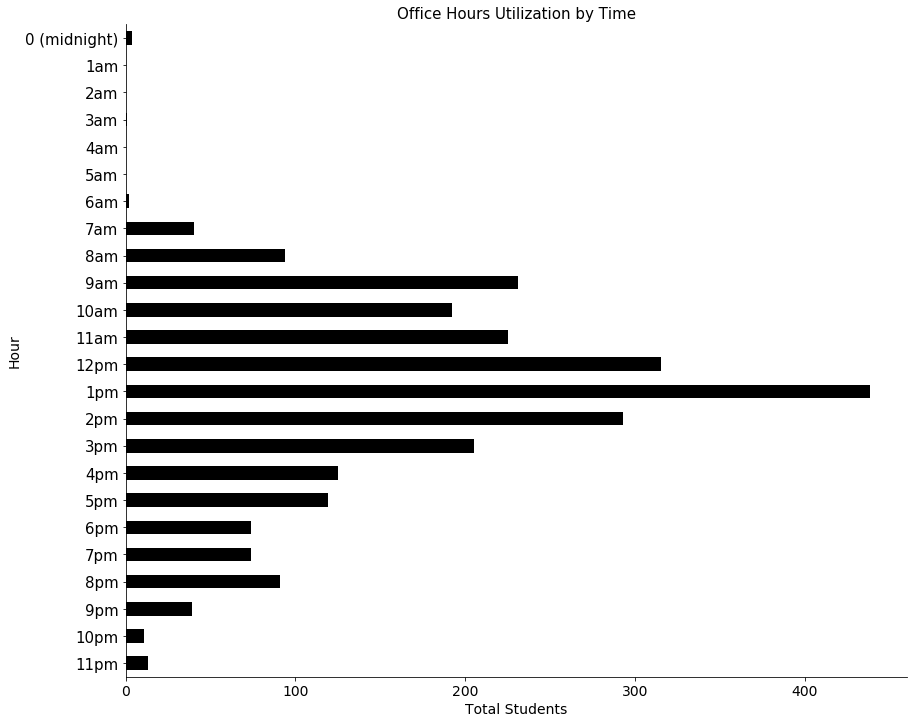

In [9]:
# 1: Display time attendance by table
def time_chart(chart=table, both='false'):
    date_dict = {}
    time_dict = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0,13:0,14:0,15:0,16:0,17:0,18:0,19:0,20:0,21:0,22:0,23:0}
    staff_time_dict = {}
    stud_time_dict = {}
    for line in chart['First join']:

        date = line.split()[0]
        time = line.split()[1]
        hour = time.split(':')[0]
        if date not in date_dict:
            date_dict[date] = 1
        else:
            date_dict[date] += 1

        time_dict[int(hour)] += 1


    time_val = []
    for num in sorted(time_dict):
        time_val.append(time_dict[num])
    headers = sorted(time_dict)
    headers.reverse()
    time_val.reverse()

    for idx,val in enumerate(headers):
        if val==0:
            headers[idx] = str(val)+' (midnight)'
        elif val < 12:
            headers[idx] = str(val)+'am'
        elif val==12:
            headers[idx] = str(val)+'pm'
        else:
            headers[idx] = str(val-12)+'pm'
    xlabel = "Total Students and Moderators"
    if (chart.equals(mod_table)):
        xlabel = 'Total Moderators'
    if (chart.equals(presenter_table)):
        xlabel = 'Total Students'

    ax = get_ax(size=(14,12), font=14)
    ax = Series(time_val).plot.barh(ax=ax, color="0")
    ax.set_title('Office Hours Utilization by Time', fontsize=15)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Hour")
    ax.set_yticklabels(headers, fontsize=15)
    return ax


time_chart(presenter_table)

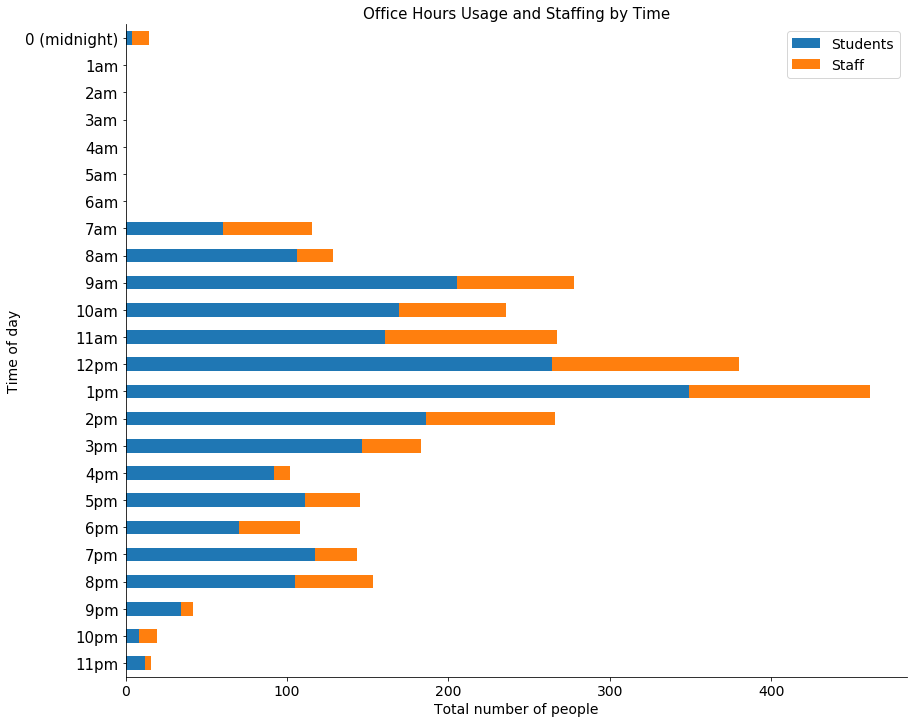

In [10]:
# 2: Utilization by Time (both students and mods)
date_dict = {}
staff_dict = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0,13:0,14:0,15:0,16:0,17:0,18:0,19:0,20:0,21:0,22:0,23:0}
stud_dict = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0,13:0,14:0,15:0,16:0,17:0,18:0,19:0,20:0,21:0,22:0,23:0}
for idx,line in table.iterrows():
    date = line['First join'].split()[0]
    time = line['First join'].split()[1]
    hour = time.split(':')[0]
    spent = convert_time(line['Total time'])
    if date not in date_dict:
        date_dict[date] = 1
    else:
        date_dict[date] += 1

    ########
    # add variable "spent" for total hours, or just append 1 for total people
    ########  
    if line['Role']=='Presenter':
        stud_dict[int(hour)] += spent
    else:
        staff_dict[int(hour)] += spent


stud_val = []
for num in sorted(stud_dict):
    stud_val.append(stud_dict[num])
mod_val = []
for num in sorted(staff_dict):
    mod_val.append(staff_dict[num])
headers = sorted(stud_dict)
headers.reverse()
stud_val.reverse()
mod_val.reverse()

for idx,val in enumerate(headers):
    if val==0:
        headers[idx] = str(val)+' (midnight)'
    elif val < 12:
        headers[idx] = str(val)+'am'
    elif val==12:
        headers[idx] = str(val)+'pm'
    else:
        headers[idx] = str(val-12)+'pm'
dfplt = pd.DataFrame({
    'Students': stud_val,
    'Staff': mod_val
},index=headers)
        
        

ax = get_ax(size=(14,12), font=14)
ax = dfplt.plot.barh(stacked=True, ax=ax)
ax.set_title('Office Hours Usage and Staffing by Time', fontsize=15)
ax.set_xlabel('Total number of people')
ax.set_ylabel("Time of day")
ax.set_yticklabels(headers, fontsize=15)
plt.show()

[8.35, -2.5500000000000007, 26.983333333333338, 56.399999999999956, 91.63333333333333, 32.300000000000004, 77.46666666666664, 82.19999999999997, 110.51666666666668, 105.6500000000002, 236.81666666666658, 148.3, 53.933333333333366, 103.21666666666668, 133.28333333333313, 84.13333333333331, 5.38333333333334, 0.5, 0, 0.0, -0.06666666666666667, 0, 0, -6.5166666666666675]


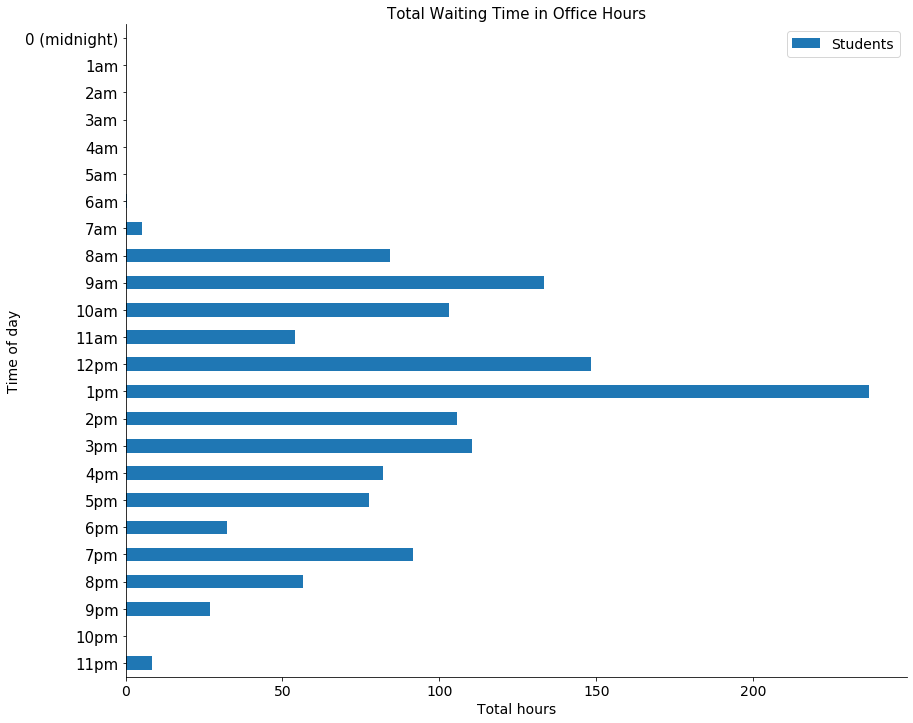

In [11]:
# 3: Total waiting time during time of day
wait_list = []
for idx,val in enumerate(stud_val):
    wait_list.append(stud_val[idx]-mod_val[idx])
print(wait_list)
dfplt = pd.DataFrame({
    'Students': wait_list
},index=headers)
        
        

ax = get_ax(size=(14,12), font=14)
ax = dfplt.plot.barh(stacked=True, ax=ax)
ax.set_title('Total Waiting Time in Office Hours', fontsize=15)
ax.set_xlabel('Total hours')
ax.set_ylabel("Time of day")
ax.set_yticklabels(headers, fontsize=15)
ax.set_xlim(0)
plt.show()

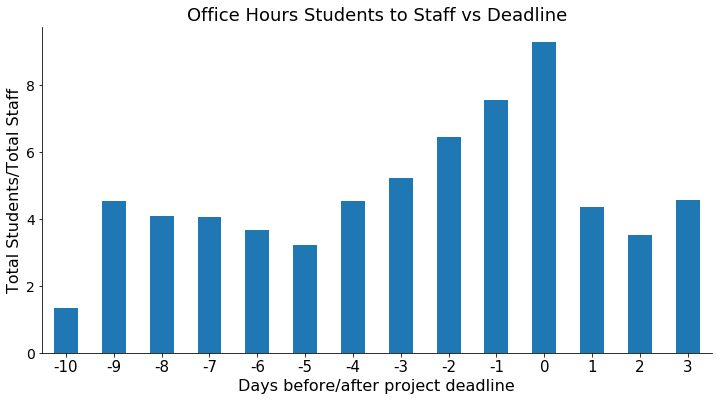

In [12]:
# Student-staff ratio vs number of days left before deadline
presenter_table
mod_table
presenter_people = {}
mod_people = {}
for idx,line in presenter_table.iterrows():
    days = line['Days before deadline']
    if days not in presenter_people:
        presenter_people[days] = 1
    else:
        presenter_people[days] += 1
for idx,line in mod_table.iterrows():
    days = line['Days before deadline']
    if days not in mod_people:
        mod_people[days] = 1
    else:
        mod_people[days] += 1

day_list = sorted(mod_people)
ratio_list = []
for day in day_list:
    if day in presenter_people and day in mod_people:
        ratio_list.append(presenter_people[day]/mod_people[day])
    else:
        ratio_list.append(-1)
day_list = day_list[0:-2]
day_list = [x * -1 for x in day_list]
ratio_list = ratio_list[0:-2]
#for idx,day in enumerate(day_list):
#    if day<0:
#        day_list[idx] = str(-1*day)+' day(s) after'
#    if day==0:
#        day_list[idx] = 'Day of Deadline'
#    if day>0:
#        day_list[idx] = str(day)+' day(s) before'

ratio_list.reverse()
day_list.reverse()
ax = get_ax(size=(12,6), font=14)
ax = Series(ratio_list[8:]).plot.bar(ax=ax)
ax.set_title('Office Hours Students to Staff vs Deadline', fontsize=18)
ax.set_ylabel('Total Students/Total Staff', fontsize=16)
ax.set_xlabel("Days before/after project deadline", fontsize=16)
ax.set_xticklabels(day_list[8:], fontsize=15, rotation=0)
plt.show()

In [14]:
pd.set_option('display.min_rows', 40)
date = '11/15/2020'
table[table['Days before deadline'] == 10] #and presenter_table['First join'].split()[0]==date]
time1 = '10:01:46'
time2 = '12:01:36'
stud_time = '11:36:56'
time2 < stud_time
table[(table['Join'] > time1) & (table['Join'] < time2)]
'''
'''

'\n'

{-10: 0.6626027460164394, -9: 3.5786155608688017, -8: 4.3439878013843645, -7: 3.1728059688789045, -6: 2.947792030875475, -5: 2.956495582119285, -4: 2.9362330368408975, -3: 3.3287388858730367, -2: 5.458833701287345, -1: 11.535592400499551, 0: 7.431454056971628, 1: 2.5957248544308333, 2: 2.69587029354063, 3: 3.5240900726924416}
[0.6626027460164394, 3.5786155608688017, 4.3439878013843645, 3.1728059688789045, 2.947792030875475, 2.956495582119285, 2.9362330368408975, 3.3287388858730367, 5.458833701287345, 11.535592400499551, 7.431454056971628, 2.5957248544308333, 2.69587029354063, 3.5240900726924416]
[-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]


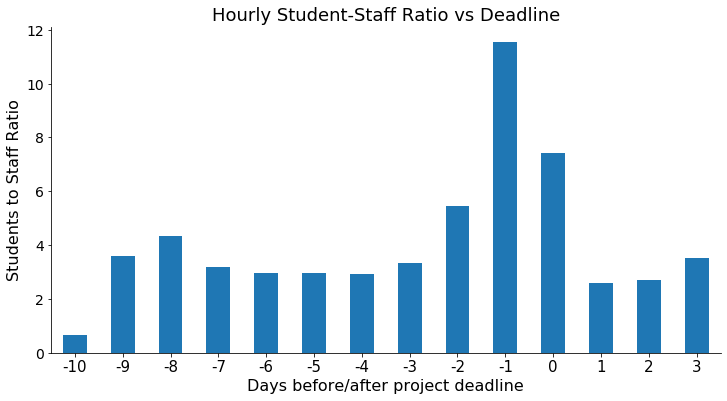

In [15]:
# Old method for calculating hourly ratio
# calculate hourly ratio = avg number of students in an hour / avg number of staff members in an hour
# avg num of students in an hour = total students/total hours spent by students
# avg num of staff in an hour = total staff members/total hours spent by staff

# New method for calculating hourly ratio
# For each moderator, add up number of 

presenter_table
mod_table
ratio_dict = {}
day_list = [10,9,8,7,6,5,4,3,2,1,0,-1,-2,-3]


for day in day_list:
    ratio_list = []
    for idx,line in mod_table[mod_table['Days before deadline']==day].iterrows():
        num_students = 0
        date = line['First join'].split()[0]
        time_join = line['First join'].split()[1]
        time_leave = line['Last leave'].split()[1]
        mod_hours = convert_time(line['Total time'])
        
        for idx,line in presenter_table[(presenter_table['Days before deadline']==day) & (presenter_table['Date']==date) & (presenter_table['Join'] > time_join) & (presenter_table['Join'] < time_leave)].iterrows():
            num_students += 1
        if (mod_hours!=0):
            ratio_list.append(num_students/mod_hours)
        
        #### PROBLEM HERE! Hours overlap. Ex: in a 1 hr session, if there are 3 students
        # and 1 staff, ratio should be 3:1. But if all students enter at the start together
        # then there is waiting time, and the avg student/hr = 3/3 hrs = 1, which is wrong!
        
        
        #print('num hours: '+str(num_hours)+", from line: "+line['Total time'])
        #print(line)
    #if num_hours == 0:
    #    print('error')
    #else:
    #    presenter_avg[-1*day] = num_people/num_hours
    ratio_dict[-1*day] = sum(ratio_list)/len(ratio_list)
    
print(ratio_dict)

vals = []
header = []
for val in ratio_dict:
    #print("days before deadline: "+str(val)+", ratio: "+str(presenter_avg[val]/mod_avg[val]))
    vals.append(ratio_dict[val])
    header.append(val)
print(vals)
print(header)

ax = get_ax(size=(12,6), font=14)
ax = Series(vals).plot.bar(ax=ax)
ax.set_title('Hourly Student-Staff Ratio vs Deadline', fontsize=18)
ax.set_ylabel('Students to Staff Ratio', fontsize=16)
ax.set_xlabel("Days before/after project deadline", fontsize=16)
ax.set_xticklabels(header, fontsize=15, rotation=0)
plt.show()


In [16]:
ll = [3,4,5,5,3]
sum(ll)/len(ll)

4.0

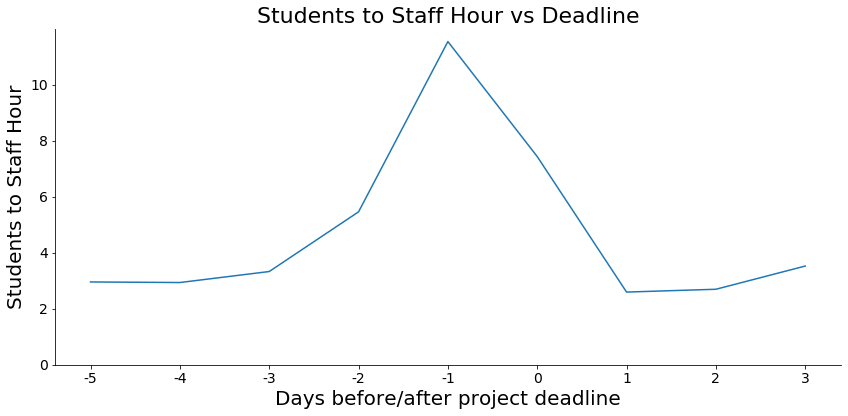

In [17]:
ax = get_ax(size=(12,6), font=14)
ax = Series(vals[5:]).plot.line()
ax.set_title('Students to Staff Hour vs Deadline', fontsize=22)
ax.set_ylabel('Students to Staff Hour', fontsize=20)
ax.set_xlabel("Days before/after project deadline", fontsize=20)
ax.set_ylim(0)
plt.xticks([0,1,2,3,4,5,6,7,8],[-5, -4, -3, -2, -1, 0, 1, 2, 3])

plt.tight_layout()
plt.savefig("project_deadlines.pdf")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3319: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


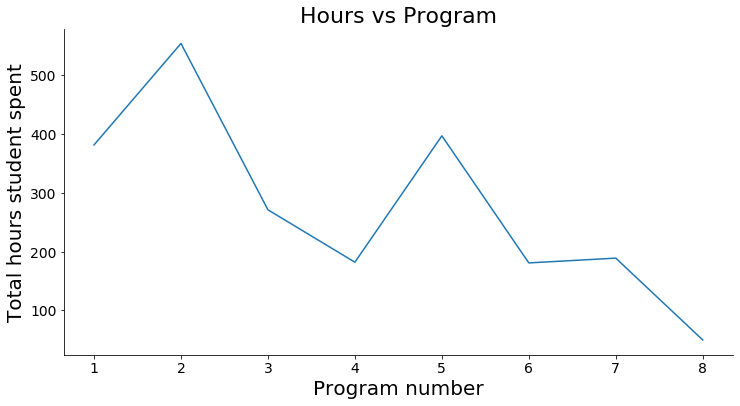

In [18]:
# 3. if we try to pair each office hour session with a project based on the date 
# (https://tyler.caraza-harter.com/cs320/f20/schedule.html), can we figure out which projects were too hard/easy?
table1 = pd.read_csv('officehours.csv', delimiter=',', error_bad_lines=False)
deadlines = ['09/23/2020','10/07/2020','10/19/2020','10/30/2020','11/11/2020','11/25/2020','12/09/2020','12/15/2020']
# assume that student come with 2 late days
deadlines_late = ['0831','0925','1009','1021','1101','1113','1127','1211','1215']
for idx,line in table1.iterrows():
    date = line['First join'].split()[0]
    date = date.split('/')[0]+date.split('/')[1]
    table1.loc[idx,'spent'] = convert_time(line['Total time'])
    table1.loc[idx,'Date'] = date
    for i in range(len(deadlines_late)-1):
        if str(deadlines_late[i]) < date and date <= deadlines_late[i+1]:
            table1.loc[idx,'program'] = i+1
presenters = table1[table1['Role'] == 'Presenter']
moderators = table1[table1['Role'] == 'Moderator']
# create df with program time for each program
program_time = presenters.groupby('program')['spent'].sum()
program_time_df = pd.DataFrame()
program_time_df['program'] = list(program_time.keys())
program_time_df['hours'] = list(program_time)

ax = get_ax(size=(12,6), font=14)
ax = Series(program_time_df['hours']).plot.line()
ax.set_title('Hours vs Program', fontsize=22)
ax.set_ylabel('Total hours student spent', fontsize=20)
ax.set_xlabel("Program number", fontsize=20)
plt.xticks([0,1,2,3,4,5,6,7],[1,2,3,4,5,6,7,8])
plt.show()

In [19]:
# 4. what percent of time do we spend helping the 10% of students that use office hours the most?
# create df with student name and their total spent hours
time_sum = presenters.groupby('Name')['spent'].sum()
student_total_time = pd.DataFrame()
student_total_time['Name'] = list(time_sum.keys())
student_total_time['hours'] = list(time_sum)
# calculate the percent
num_diff_student = len(student_total_time)
num_10_percent = math.floor(num_diff_student/10)
top_10_percent = student_total_time.sort_values('hours', ascending=False)[:num_10_percent]
round(sum(top_10_percent['hours'])/sum(student_total_time['hours']) * 100, 2)

37.23

In [20]:
# 4. ^ You're right!
time_dict = {}
for idx, line in presenters.iterrows():
    if line['Name'] not in time_dict:
        time_dict[line['Name']] = convert_time(line['Total time'])
    else:
        time_dict[line['Name']] += convert_time(line['Total time'])

time_list = sorted(list(time_dict.values()), reverse=True)
top_percent = math.floor(0.1*len(time_list))
sum(time_list[:top_percent])/sum(time_list)

0.37232875676084565

In [21]:
# 5. What % do students spend waiting?
# Note: waiting time = student time - staff time
wait_list = [x for x in wait_list if x >= 0]
print('% time students spend waiting: '+'{:.2f}%'.format(100*sum(wait_list)/sum(stud_val)))

% time students spend waiting: 61.59%


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


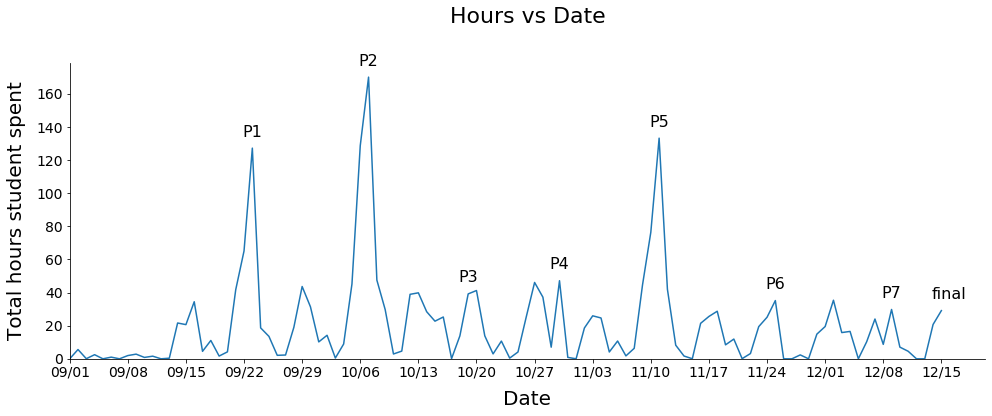

In [22]:
# 6. Time series to show spikes throughout the semester
dl = [x[0:-5] for x in deadlines]
proj = ['P1','P2','P3','P4','P5','P6','P7','final']
for idx, row in presenter_table.iterrows():
    presenter_table.loc[idx,'Time'] = row['First join'].split()[1]
    presenter_table.loc[idx,'Hours'] = convert_time(row['Total time'])
    presenter_table.loc[idx,'m/d'] = row['Date'][:-5]
date_series = presenter_table.groupby('m/d')['Hours'].sum()[0:-1]


month_dict = {
    '09':30,
    '10':31,
    '11':30,
    '12':15
}
for month in month_dict:
    for day in range(1, month_dict[month]):
        date = str(month) + str("/{:02d}".format(day))
        if date not in date_series:
            date_series[date] = 0
date_series = date_series.sort_index()


ax = get_ax(size=(14,6), font=14)
ax = date_series.plot(x_compat = True)
ax.set_title('Hours vs Date', fontsize=22, pad=40)
ax.set_ylabel('Total hours student spent', fontsize=20, labelpad=10)
ax.set_xlabel("Date", fontsize=20, labelpad=10)
ax.set_xlim(0)
ax.set_ylim(0)
skip = 7
plt.xticks(list(range(0,len(list(date_series.index))))[::skip],list(date_series.index)[::skip])

style = dict(size=16,color='black')
marg1 = 1.2
marg2 = 7
for i in range(len(dl)):
    ax.text(date_series.index.get_loc(dl[i])-marg1, date_series[dl[i]]+marg2, proj[i], **style)

plt.tight_layout()
plt.savefig("timeseries.pdf")